In [4]:
!pip install tensorflow==2.13.0
!pip install tflite-support==0.4.3

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Found 2150 images belonging to 50 classes.
Found 350 images belonging to 50 classes.
Epoch 1/50
33/33 [==============================] - 61s 2s/step - loss: 4.0289 - accuracy: 0.0772 - val_loss: 3.6476 - val_accuracy: 0.1719
Epoch 2/50
33/33 [==============================] - 53s 2s/step - loss: 3.3574 - accuracy: 0.2282 - val_loss: 2.8629 - val_accuracy: 0.3562
Epoch 3/50
33/33 [==============================] - 53s 2s/step - loss: 2.7784 - accuracy: 0.3452 - val_loss: 2.3131 - val_accuracy: 0.4844
Epoch 4/50
33/33 [==============================] - 53s 2s/step - loss: 2.3850 - accuracy: 0.4286 - val_loss: 1.9627 - val_accuracy: 0.5688
Epoch 5/50
33/33 [==============================] - 54s 2s/step - loss: 2.0892 - accuracy: 0.4952 - val_loss: 1.6884 - val_accuracy: 0.6344
Epoch 6/50
33/33 [==============================] - 54s 2s/step - loss: 1.9052 - accuracy: 0.5441 - val_loss: 1.5792 - val_accuracy: 0.6469
Epoch 7/50
33/33 [==============================] - 54s 2s/step - loss: 1.7

INFO:tensorflow:Assets written to: C:\Users\henry\AppData\Local\Temp\tmpsijz4zhx\assets


INFO:tensorflow:Assets written to: C:\Users\henry\AppData\Local\Temp\tmpsijz4zhx\assets


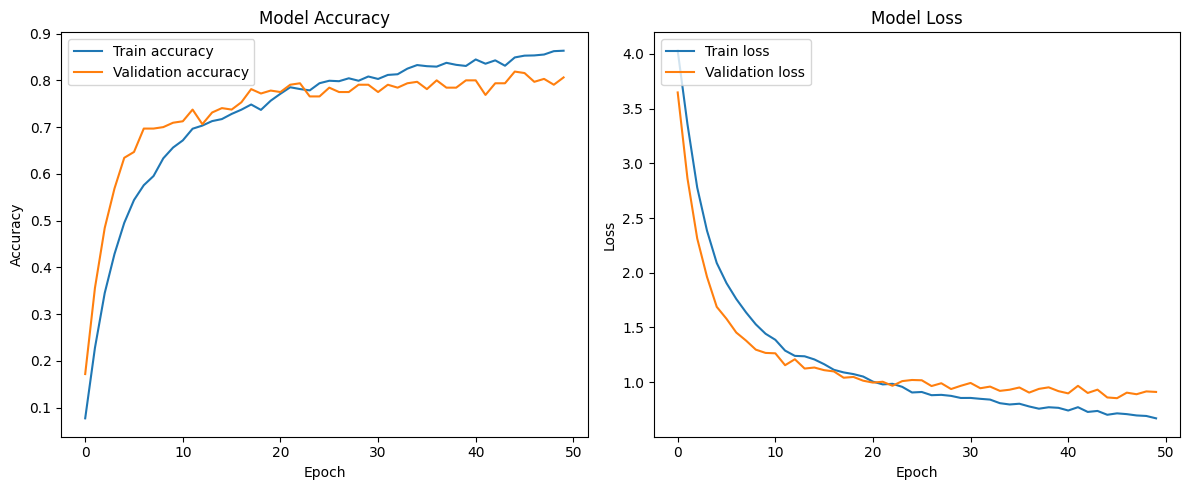

Number of training samples: 2150
Number of validation samples: 350


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Define paths and set hyperparameters
train_data_dir = '../data/train'

# Function to exclude the '.ipynb_checkpoints' directory
def filter_folders(directory):
    return [folder for folder in os.listdir(directory) if folder != '.ipynb_checkpoints']

img_height, img_width = 224, 224
batch_size = 64
epochs = 50
learning_rate = 0.0005  # Reduced learning rate for smoother convergence

seed_value = 42

# Set seed for reproducibility
tf.random.set_seed(seed_value)

# Data Preprocessing with 15% validation split and enhanced augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],  # Adjust brightness for more robust training
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # 15% for validation
)

# No augmentation for validation data, just rescaling
validation_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.15)

# Load training data (85% training)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # 85% training split
    classes=filter_folders(train_data_dir)
)

# Load validation data (15% validation)
validation_generator = validation_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # 15% validation split
    classes=filter_folders(train_data_dir)
)

# Load the pre-trained MobileNetV2 model, excluding its top layers
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Set base layers to train partially (fine-tuning), using gradual unfreezing
base_model.trainable = False

# Build the model (Custom Head)
model = models.Sequential([
    base_model,  # Pre-trained MobileNetV2 as feature extractor
    layers.GlobalAveragePooling2D(),  # Pooling layer
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization to prevent overfitting
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
)

# Save the trained model
model.save('../models/MobileNetV2_Plant_Identification_Model.keras')

# Convert to TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('../models/MobileNetV2_Plant_Identification_Model.tflite', 'wb') as f:
    f.write(tflite_model)

# Plot the training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# 14. Optionally, print the number of samples
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")

In [6]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata_writers as writer_utils
from tflite_support.metadata_writers import image_classifier
import os

"""Creates the metadata for an image classifier."""

# Load your TensorFlow Lite model file
model_file = "../models/MobileNetV2_Plant_Identification_Model.tflite"

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV2 Plant Identification Model"
model_meta.description = ("This model identifies plant species based on input images. "
                          "It classifies the plant into one of the known categories of plant species.")
model_meta.version = "v1"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License, Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "input_image"
input_meta.description = (
    "Input image for plant species identification. The image should be resized to 224 x 224 pixels "
    "with three RGB channels. Each value in the tensor is a single byte between 0 and 255.")
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)

input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [0.0]  # Normalization mean
input_normalization.options.std = [255.0]   
input_meta.processUnits = [input_normalization]

input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "plant_probability"
output_meta.description = "Probabilities corresponding to different plant species classifications."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)

output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats

label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels.txt") 
label_file.description = "Labels for plant species that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

# Creates Flatbuffer metadata
b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

# Pack metadata and associated files into the model
populator = _metadata.MetadataPopulator.with_model_file(model_file)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels.txt"]) 
populator.populate()

# Verify the metadata generated by the populator
print("Metadata populated successfully.")

ValueError: File, 'labels.txt', has already been packed.

In [2]:
import numpy as np
import os
import tensorflow as tf
from PIL import Image

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="../models/MobileNetV2_Plant_Identification_Model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to match model input
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array.astype(np.float32)

# Function to get class names based on the provided mapping
def get_class_names():
    return [
        'Aloe Vera',
        'Alsike Clover',
        'Annual Mercury',
        'Basil',
        'Bee Orchid',
        'Biting Stonecrop',
        'Black Henbane',
        'Bougainvillea',
        'Bull Thistle',
        'Canada Thistle',
        'Carrot',
        'Common Hop',
        'Damask Rose',
        'Flowering Rush',
        'Fly Orchid',
        'French Marigold',
        'Garlic Mustard',
        "Goat's Rue",
        'Golden Pothos',
        "Hare's-Foot Clover",
        'Henbit Deadnettle',
        'Hibiscus Flower',
        'Hollyhock',
        'Inchplant',
        'Ivy-leaved Pelargonium',
        'Lactuca Virosa',
        'Large Hop Clover',
        'Lavender',
        'Male Fern',
        'Monstera',
        'Oak-leaved Pelargonium',
        'Opium Poppy',
        'Pandan',
        "Perforate St. John's Wort",
        'Pomegranate',
        'Poppy Anemone',
        'Pot Marigold',
        'Purple Dead-Nettle',
        'Red Clover',
        'Rose Geranium',
        'Royal Fern',
        'Shrubby Gromwell',
        'Snake Plant',
        'Strawberry Clover',
        'Sword Fern',
        'Tutsan',
        'Water Lily',
        'White Water Lily',
        'Wild Strawberry',
        'Zonal Geranium'
    ]

# Main function to classify images in a directory
def classify_images_in_directory(directory):
    # Get the class names based on the predefined list
    class_names = get_class_names()  # Adjust this to reflect your classes

    # Iterate through files in the directory
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            print(f"Classifying image: {img_file}")  # Debugging line
            img_array = preprocess_image(img_path)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], img_array)

            # Run the model
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])
            confidence_scores = output_data[0]

            # Get predicted class index
            predicted_class_index = np.argmax(confidence_scores)
            confidence = confidence_scores[predicted_class_index]

            # Print the class name and confidence
            print(f"Image: {img_file}, Predicted Class: {class_names[predicted_class_index]}, Confidence: {confidence:.4f}")

# Change this directory to the path where your images are stored
image_directory = '../data/test' 
classify_images_in_directory(image_directory)

Classifying image: aloe_vera_testing_006.png
Image: aloe_vera_testing_006.png, Predicted Class: Aloe Vera, Confidence: 0.9980
Classifying image: damask_rose_testing_007.png
Image: damask_rose_testing_007.png, Predicted Class: Damask Rose, Confidence: 0.9984
Classifying image: golden_pothos_testing_001.png
Image: golden_pothos_testing_001.png, Predicted Class: Golden Pothos, Confidence: 0.9677
Classifying image: hibiscus_flower_testing_004.png
Image: hibiscus_flower_testing_004.png, Predicted Class: Hibiscus Flower, Confidence: 0.3154
Classifying image: hibiscus_flower_testing_005.png
Image: hibiscus_flower_testing_005.png, Predicted Class: Hibiscus Flower, Confidence: 0.9338
Classifying image: pandan_testing_003.png
Image: pandan_testing_003.png, Predicted Class: Pandan, Confidence: 0.9821
Classifying image: red_clover_testing_002.jpg
Image: red_clover_testing_002.jpg, Predicted Class: Alsike Clover, Confidence: 0.7928
